# Checkpoint 5

In [317]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, norm, poisson, chi2
from scipy.special import erfinv
from scipy.integrate import quad
from iminuit import Minuit

### Problem #1 (2 points):
A company manufacturing computer monitors claims that the faulty rate of the screen population is 5%. We want to test if the claim is true. We have ordered a sample of 100 monitors to test. We choose <i>t</i><sub>cut</sub> = 9 as the maximum number of faulty monitors that we are willing to have and still accept that the manufacturer’s claim is true.
<br>
<br>
(a) What is the significance level (Type-I error), <i>α</i>, of the chosen threshold? <br>
(b) What is the probability <i>β</i> of a Type-II error if the true faulty rate is 15%?
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;NB: we can only compute the Type-II error for a concrete H1 scenario (<i>i.e.</i> fixed faulty rate), but not if the faulty rate is unknown!<br>
<br>
Hint: Use ```scipy.stats.binom``` (scipy’s binomial distribution) and its method ```pmf```.

In [318]:
n = 100
p = 5/n
t_cut = 9
p_true = 15/100

Part a)

In [319]:
dist = binom(n, p)

#Taking the opposite probibabilty and then subtracting by one to accomodate for infinity values
alpha = 1 - np.sum(dist.pmf(np.arange(0, t_cut+1)))
print("The significance level is found as for the Type-I error is:", alpha)

The significance level is found as for the Type-I error is: 0.028188294163416727


Part b)

In [320]:
dist = binom(n, p_true)
beta = np.sum(dist.pmf(np.arange(0, t_cut+1)))
print("The probability beta of a Type-II error is found as:", beta)

The probability beta of a Type-II error is found as: 0.05509463169229438


## Problem #2 (3 points):
A Time-of-Flight (ToF) system designed to separate kaons (m<sub>K</sub> = 493.7 MeV/<i>c</i><sup>2</sup>) from pions (<i>m<sub>π</sub></i> = 139.6 MeV/<i>c</i><sup>2</sup>) consists of two scintillation counters that are a distance <i>L</i> = 20 m apart. For a particle with mass <i>m</i> and momentum <i>p</i>, the time needed to travel between the two scintillators is <br>
$$t = \frac{L}{c} \times \sqrt{1 +\left(\frac{mc}{p}^{2}\right)} $$
<br> where $c$ = 3 × 10<sup>8</sup> m/s is the speed of light in vacuum. The time resolution of the ToF system is <i>σ</i> = 400 ps (i.e. for an average time $t$, the time reported by the system follows a Gaussian distribution with mean $t$ and width $σ$).<br>
<br>
(a) Write a ```Gaussian``` class that calculates the integral between an arbitrary point ```xval``` and $\pm \infty$. Name these methods ```integralAbove``` and &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;```integralBelow```, to be used for calculating <i>α</i> and <i>β</i> values, as discussed below.
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Hint: You should try to recycle some of the code developed for the Week-8, CP #4 in order to save time. Be careful to choose practical values for $\pm \infty$! 
<br>
<br>(b) Create another class ROC that calculates (α<sub>i</sub>, β<sub>i</sub>) pairs of ToF performancefor distinguishing between pions and kaons for a given momentum p and &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;an arbitrary threshold $t^{i}_{cut}$. Use the class to produce 100 performance points evenly spaced between the average travel times for kaons and pions. <br>
<br>(c) Create a single plot that overlays the ROC kaon-pion separation curves for $p$ = 3 GeV/$c$, $p$ = 4 GeV/$c$ and $p$ = 6 GeV/$c$. Which momentum value &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;gives better performance and why?
<br>
<br>Hint: it is more practical to use natural units than SI in the code implementation.

Part a)

In [321]:
# Gaussian class recycled from week 8
class gaussian:
    def __init__(self, L, mass, p, sigma):
        self.mean = (L/(3*10**8)) * np.sqrt(1 + np.square(mass/p))
        self.sigma = sigma
        self.pdf = norm(self.mean, self.sigma).pdf

    #def evaluate(self):
    #    return np.random.normal(self.mean, self.sigma)

    def integralAbove(self, xval):
        #right-ward
        return (1 - quad(self.pdf, 0, xval)[0])
    
    def integralBelow(self, xval):
        #left-ward
        return (quad(self.pdf, 0, xval)[0])

Part b)

In [322]:
class ROC:
    def __init__(self, no_of_events, L, mass_k, mass_p, p, sigma):
        self.gauss_pion = gaussian(L, mass_p, p, sigma)
        self.gauss_kion = gaussian(L, mass_k, p, sigma)
        self.event_No = np.linspace(self.gauss_pion.mean, self.gauss_kion.mean, no_of_events)
        
    def evaluate(self):
        alpha_vals = []
        beta_vals = []
        for x in self.event_No:
            alpha_vals.append(self.gauss_pion.integralAbove(x))
            beta_vals.append(self.gauss_kion.integralBelow(x))
    
        return np.array(alpha_vals), np.array(beta_vals)


In [323]:
L = 20 #m/s
m_k = 493.7 #MeV/c^2
m_pi = 139.6 #MeV/c^2
number_cuts = 100

sigma = 400*10**(-12) #s

In [324]:
p_3 = 3*(10**(3)) #MeV/c
error_vals_3 = ROC(number_cuts, L, m_k, m_pi, p_3, sigma).evaluate()

In [325]:
p_4 = 4*(10**(3)) #MeV/c
error_vals_4 = ROC(number_cuts, L, m_k, m_pi, p_4, sigma).evaluate()

In [326]:
p_6 = 6*(10**(3)) #MeV/c
error_vals_6 = ROC(number_cuts, L, m_k, m_pi, p_6, sigma).evaluate()

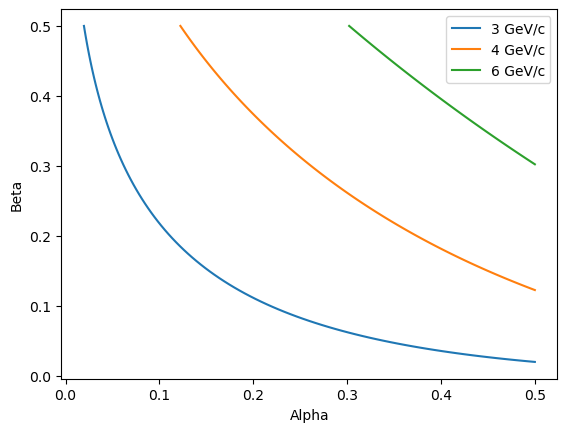

In [327]:
plt.plot(error_vals_3[0], error_vals_3[1], label="3 GeV/c")
plt.plot(error_vals_4[0], error_vals_4[1], label="4 GeV/c")
plt.plot(error_vals_6[0], error_vals_6[1], label="6 GeV/c")

plt.xlabel("Alpha")
plt.ylabel("Beta")
plt.legend()
plt.show()

Where the momentum is defined as equal to 3 GeV/$c$ will give the best performance since this curve is closet to the 0-point of the graph and therefore, will have the point that is closest to the center (0, 0). For this curve, the alpha and beta values are best compared the the larger momentums.

## Problem 3

In 1992, the ARGUS $e^{+}e^{−}$ experiment reported the observation of the charmed anddoubly strange baryon $\Omega_{c}$ through its decay channel $\Xi^{−}\Kappa^{−}\pi^{+}\pi^{+}$. The obtained mass spectrum is shown in the figure below.

total # of events= 43.0  # of bins= 50


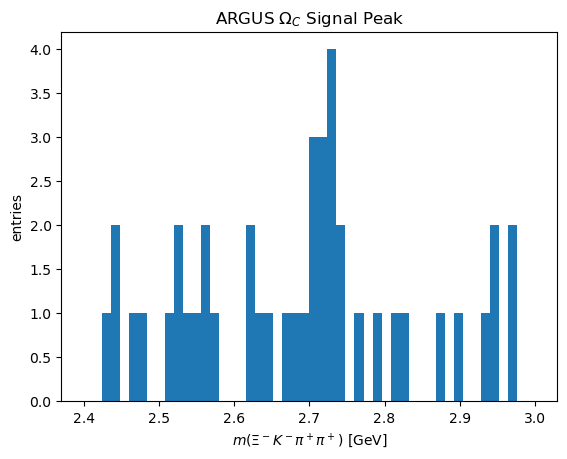

Figure 6: The invariant-mass spectrum reported by the ARGUS experiment.


In [328]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

nbins = 50
XMIN = 2.4 # in GeV
XMAX = 3.0 # in GeV

bins = np.linspace(XMIN, XMAX, nbins)
counts = np.array ([0 , 0 , 1 , 2 , 0 , 1 , 1 , 0 , 0 , 1 , 2 , 1 , 1 , 2 , 1 , 0 , 0 , 0 , 2 , 1 , 1 , 
                    0 , 1 , 1 , 1 , 3 , 3 , 4 , 2 , 0 , 1 , 0 , 1 , 0 , 1 , 1 , 0 , 0 , 0 , 1 , 0 , 1 , 0 , 
                    0 , 1 , 2 , 0 , 2 , 0 , 0]).astype(float)

tot = 0
for i in counts:
    tot += i

print("total # of events=" , tot, " # of bins=", len(counts))

plt.hist(bins, bins=len(counts), weights=counts, range=(min(bins), max(bins)))
plt.xlabel("$m(Ξ^- K^- π^+ π^+$) [GeV]")
plt.ylabel("entries")
plt.title("ARGUS Ω$_C$ Signal Peak")
plt.show()
print("Figure 6: The invariant-mass spectrum reported by the ARGUS experiment.")

You should get a total of 43 events and 50 bins in the printout.<br>
<br>
3.1 (a) Assuming that all the events are caused by background, calculate the average number of backgrounds events per bin.<br>
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
(b) Use method numpy.argmax to find the location of the peak in the massspectrum (in GeV).<br>
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
(c) Define a $\pm 2.5 \sigma$ window around the peak ($\sigma$ = 12 MeV, the width of the histogram bin), and count the total number of events $N_{obs}$ in this window &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(use 5 bins in total, with the middle bin containing the peak).<br>
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
(d) Estimate the number of expected background events within the windowNbgd, and calculate the probability for a Poisson distribution with mean &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$N_{bgd}$ to produce $N_{obs}$ or more events, and the number of standard deviations it corresponds to.<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Hint #1: Use ```scipy.stats.poisson``` (scipy’s Poisson distribution), and its method ```pmf``` or ```sf```.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Hint #2: Use ```scipy.special.erfinv(1 - pvalue) * np.sqrt(2)``` to convert a p-value into the corresponding number of standard deviations.<br>
<br><br>
3.2 We will repeat the significance evaluation, this time by doing a signal-plus-background (H1) and a background-only (H0) fits. Most of the code we will &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;need here has been developed in (and can be recycled from) the Week-8, CP#4.<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(a) Write two classes, ```Flat``` (to describe the flat background), and ```Gaussian``` (to describe the hypothetical signal). Class ```Flat``` should be a simplified &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;version of class ```Linear``` developed for the Week-8, CP#5.<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(b) We will need a minimiser that returns the $\chi^{2}$ (as minimised by the fit). As discussed in previous weeks, you are welcome to use your favourite &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;minimiser (and you should really have one available by now). Examples: ```iminuit```, your own custom implementation of the log-likelihood, or the($\chi^{2}$&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-equivalent of the) log-likelihood for a binned fit, as described in theWeek-8 lecture notes (and in Ref. [6]).<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(c) Unlike what we had done in Week-8, here we will assume that we do notknow the location (i.e. Gaussian mean) of the hypothetical signal, but we &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;do know its width (Gaussian sigma, equal to the width of the histogram bin). We will perform $1 + N$ fits: the first one for the H0 hypothesis, and &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;the remaining $N$ fits will scan the mass spectrum by assuming each time that the location of the signal is fixed at the centre of the $i$-th bin. For &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;each of the $N$ fits, calculate the $\chi^2(H0) − \chi^2(H1)$ difference. Put all these values into a histogram with the mass value indicating the Gaussian &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;mean as the abscissa (i.e. the x-coordinate), and plot it.<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(d) Find the maximum value of the $\chi^2(H0) − \chi^2(H1)$ array (using ```numpy.amax```). Use (Wilk’s theorem, and) previously seen scipy methods &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;```stats.chi2.cdf``` and ```special.erfinv``` to calculate the significance of the deviation.

#### 3.1

Part a)

In [329]:
counts_bin = np.average(counts)
print("The average number of background events per bin is:", counts_bin)

The average number of background events per bin is: 0.86


Part b)

In [330]:
peak_i = np.argmax(counts)
print("The location where the peak in the mass spectrum is:", peak_i)

The location where the peak in the mass spectrum is: 27


Part c)

In [331]:
sigma = 0.012 #GeV
width_half = np.round(2.5)

peak = np.average(counts)
N_obs = np.sum(counts[int(peak_i-width_half):int(peak_i+width_half)])
print("The total number of counts within this plus or minus 2.5 window:", N_obs)

The total number of counts within this plus or minus 2.5 window: 12.0


Part d)

In [332]:
tot_bkg_window = counts_bin*5
print("No of excepted background events:", tot_bkg_window)

dist = poisson(tot_bkg_window)
p_val = 1 - np.sum(dist.pmf(np.arange(0, N_obs)))
print("Probability of producing N_obs or more:", p_val)

z_score = erfinv(1 - p_val) * np.sqrt(2)
print("The number of standard deviations this probability corresponds to is:", z_score)

No of excepted background events: 4.3
Probability of producing N_obs or more: 0.0016660844240050654
The number of standard deviations this probability corresponds to is: 3.1440825339336467


#### 3.2

Part a)

In [333]:
# Class recycled from week 8 (Linear)
# Removed any slope arguments since model is flat which would output a horizontal line
class flat:
    def __init__(self, intercept, lolimit, hilimit):
        self.intercept = intercept
        self.lolimit  = lolimit 
        self.hilimit = hilimit
       
    def evaluate(self, t):
        return self.intercept
    
    def integral(self):
        return quad(self.evaluate, self.lolimit, self.hilimit)[0]
    


# Gaussian recycled from week 8
class gaussian:
    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma
        self.pdf = norm(self.mean, self.sigma).pdf

    def evaluate(self, x):
        return np.exp(-(x-self.mean)**2/(2*(self.sigma**2)))

    def integralAbove(self, xval):
        #right-ward
        return (1 - quad(self.pdf, 0, xval)[0])
    
    def integralBelow(self, xval):
        #left-ward
        return (quad(self.pdf, 0, xval)[0])

Part b, c)

In [334]:
obs_data = {
    'x': bins,
    'y': counts
}
sigma = 0.012

```
NOTE: Using a plus 1 factor to y-dataset inside the minimising function to avoid undiviable floats, nan and infinity values that stop the minimiser from finiding the minimum. The intercept is corrected by substracting by this factor after minimisation to get the true intercept along with it's χ2
```

In [335]:
def min_chi2_H0(intercept): 
    # Defined a Minuit specific funtion for chi^2 minimisation
    # for null Hypothesis only, therefore set with only flat model
    model = flat(intercept, XMIN, XMAX)
    
    total = 0.
    for x, N_obs in zip(obs_data['x'], obs_data['y']+1):
        N_exp = model.evaluate(x)
        if N_exp == 0.:
            N_exp = 1e-3

        total += (N_exp - N_obs + (N_obs*np.log(N_obs/N_exp)))
    return (2*total)


Min_data = []
Chi_2 = []

startvals_H0 = {
    'intercept': 1.8,
}

Min_H0 = Minuit(min_chi2_H0, **startvals_H0)
Min_H0.hesse()
Min_H0.migrad()  # find minimum

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 21.67                      │              Nfcn = 20               │
│ EDM = 9.45e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ intercept │   1.86    │   0.19    │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬───────────┐
│           │ intercept │
├───────────┼───────────┤
│ intercept │     0.036 │
└───────────┴───────────┘

In [336]:
intercept_H0 = Min_H0.values['intercept']-1
Chi_2_H0 = min_chi2_H0(intercept_H0)
print("The intercept is found at", intercept_H0, "with a χ^2 of", Chi_2_H0)

The intercept is found at 0.8580643598860185 with a χ^2 of 65.37459450353077


In [337]:
def min_chi2_H1(intercept, mean):
    # Defined a Minuit specific funtion for chi^2 minimisation
    # for null Hypothesis only, therefore set with flat + guassian model

    lin = flat(intercept, XMIN, XMAX)
    gauss = gaussian(mean, (12/1000))

    total = 0.
    for x, N_obs in zip(obs_data['x'], obs_data['y']+1):
        N_exp = lin.evaluate(x) + gauss.evaluate(x)
        if N_exp == 0.:
            N_exp = 1e-20
        
        total += (N_exp - N_obs + (N_obs*np.log(N_obs/N_exp)))
    return (2*total)

Chi_2_diff = []
for i in bins:
    startvals_H1 = {
            'intercept': 1,
            'mean': i
        }

    Min_H1 = Minuit(min_chi2_H1, **startvals_H1)
    Min_H1.fixed['mean'] = True
    Min_H1.hesse()
    Min_H1.migrad()  # find minimum

    Chi_2_H1 = min_chi2_H1(Min_H1.values['intercept']-1, Min_H1.values['mean'])
    Chi_2_diff.append(Chi_2_H0 - Chi_2_H1)

Chi_2_diff = np.array(Chi_2_diff)

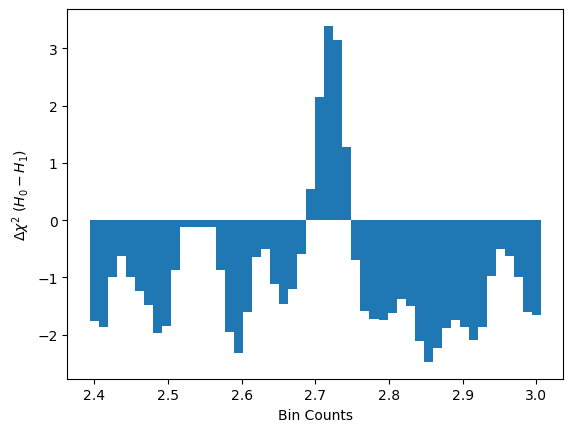

In [338]:
plt.bar(bins, Chi_2_diff, width=(bins[1]-bins[0]))
plt.xlabel("Bin Counts")
plt.ylabel("$\Delta\chi^2$ $(H_{0}-H_{1})$")
plt.show()

Part d)

In [339]:
Chi_2_diff_max = np.amax(Chi_2_diff)
print("The maximum χ2 calculated is:", Chi_2_diff_max)

The maximum χ2 calculated is: 3.394487652141585


In [348]:
p_val = 1 - chi2.cdf(Chi_2_diff_max, 1)
print("The p-value found using Wilk's Theorem on the hypothesis test is:", p_val)

The p-value found using Wilk's Theorem on the hypothesis test is: 0.06541468274808526


In [349]:
z_score = erfinv(1 - p_val)*np.sqrt(2)
print("The Z-score for the hypothesis test is:", z_score)

The Z-score for the hypothesis test is: 1.8424135399365653
